In [433]:
import s3fs
import pandas as pd
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "jhajjar"
FILE_PATH_S3 = f"{MY_BUCKET}/Diffusion/clean_data.csv"
with fs.open(FILE_PATH_S3, "r") as file_in:
    df = pd.read_csv(file_in)

df

,id,type,nb_pieces,loc,surface,prix,loc1,loc2,loc3,loc1_x,loc1_y,loc2_x,loc2_y,loc3_x,loc3_y
0,apimo-85473173,Appartement,1,75001 Paris 1er (Châtelet - Les Halles),29,364000,Châtelet - Les Halles,Quartier Les Halles,75001,48.862509,2.346443,48.862373,2.345313,48.864614,2.334396
1,hektor-Les-4-Quartiers-383,Appartement,1,75001 Paris 1er (Châtelet - Les Halles),23,301000,Châtelet - Les Halles,Quartier Les Halles,75001,48.862509,2.346443,48.862373,2.345313,48.864614,2.334396
2,hektor-PARISLUXURYHOMES-4007,Appartement,5,75002 Paris 2e (Palais Royal),106,2490000,Palais Royal,Quartier du Palais Royal,75001,48.863585,2.336204,48.864603,2.336049,48.864614,2.334396
3,ag754594-448898324,Studio,1,75001 Paris 1er (Saint-Germain - L'Auxerrois),27,365000,Saint-Germain,NaN,75006,48.856553,2.333331,NaN,NaN,48.850433,2.332951
4,keller-williams-1-34_1_53-180645,Appartement,2,75001 Paris 1er (Vendôme),67,1190000,Vendôme,Quartier Vendôme,75001,48.866900,2.328549,48.866900,2.328549,48.864614,2.334396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10054,apimo-83966258,Appartement,1,75020 Paris 20e (Père Lachaise - Réunion),22,239000,Père Lachaise,Quartier du Père-Lachaise,75020,48.861130,2.394009,48.863752,2.395302,48.865042,2.398929
10055,ag755800-412953689,Appartement,1,75020 Paris 20e (Père Lachaise - Réunion),35,239600,Père Lachaise,Quartier du Père-Lachaise,75020,48.861130,2.394009,48.863752,2.395302,48.865042,2.398929
10056,century-21-202_480_27885,Appartement,3,75020 Paris 20e (Plaine - Lagny),63,539000,Plaine,Quartier de Charonne,75020,48.850152,2.402190,48.855145,2.397638,48.865042,2.398929
10057,netty-company34605jrw-appt-3212,Appartement,1,75020 Paris 20e (Gambetta),27,215000,Gambetta,Quartier du Père-Lachaise,75020,48.864933,2.398054,48.863752,2.395302,48.865042,2.398929


Le dataframe issu du scraping comporte 10101 entrées et 15 variables.\
La variable "id" correspond à l'identifiant unique que le site donne à chaque annonce. Il est souvent composé du nom de l'agence immobilière et d'une suite de nombres.\
La variable "type" décrit le type du bien immobilier : appartement, maison, studio, hôtel, loft/atelier/surface.\
la variable "Nb_chambre" correspond au nombre de pièces dans le logement. Par "pièces" on entend une pièce principal comme une chambre, un salon par exemple. (la cuisine / salle de bains / toilettes / couloirs / entrée n'étant pas comptés).\
La variable "loc1" indique la localisation du logement. Il ne s'agit pas d'une dénomination officielle mais de "sous-quartiers" arbitraires définis par un organisme nommé "Kelquartier", offrant des services d'informations aux plateformes immobilières.\
Comme vu précedemment, "loc2" correspond au quartier correspondant (grâce à l'API) et loc3 à l'arrondissement. Pour chacune de ces variables de localisation on a grâce à l'API de geopy, des longitudes (x) et latitudes correspondants (y)\
La variable "surface" est la superficie en mètre carré (loi Carrez) du logement. Finalement, la variable "prix" contient le prix en euros listé sur le site Bien'ici du bien immobilier en question.

Dans un premier temps nous allons nous focaliser sur les données issues du scraping, puis, dans une seconde partie, nous allons exploiter les données géographiques enrichies. Ainsi, pour le moment, nos analyses se concentreront sur les colonnes "id", "type", "nb_pièce", "prix", "surface", "loc1" 

Nous créons une colonne 'prix/m2'. En effet, à des fins de comparaison, analyser simplement le prix n'a pas vraiment de sens sans prendre en compte la surface du bien.

In [434]:
df["prix/m2"] = df["prix"] / df["surface"] #création de la colonne prix du m2
colonnes_analyses = ["id", "type", "nb_pieces", "prix", "prix/m2","surface", "loc1"]

Afin de mieux appréhender notre dataframe, nous utilisons la fonction describe() de pandas. 

In [435]:
colonnes_descriptions = ["nb_pieces", "prix", "prix/m2", "surface"]
description_df = df[colonnes_descriptions].describe()
description_formattée = description_df.map(lambda x: f"{x:.2f}")  # écriture non scientifique et 2 chiffres après la virgule pour améliorer la clarté.
description_formattée

,nb_pieces,prix,prix/m2,surface
count,10059.00,10059.00,10059.00,10059.00
mean,2.78,746074.90,11011.35,64.82
std,1.54,798719.49,3563.19,48.90
min,1.00,22000.00,545.45,4.00
25%,2.00,323000.00,8959.69,32.00
50%,2.00,530000.00,10369.57,52.00
75%,4.00,850000.00,12258.19,82.00
max,17.00,15000000.00,52500.00,448.00


Avant d'interpréter les données, il est évident que plusieurs données résultent d'une anomalie/erreur de listing sur le site (ce ne sont pas des "outliers" mais des erreurs). Le prix minimum de 22 0000 € parait impossible pour les types de biens que nous avons retenu. Similairement, un prix du m2 de 545.54 n'est pas cohérent avec le marché parisien. Comme les valeurs maximales de nos variables paraissent possible (segment d'ultra luxe), nous nous concentrons sur les valeurs minimales afin de détecter une anomalie. Comme le prix du m2 prend en compte le prix et la surface nous commencons par cette variable. Nous supprimons la ligne associée à cette erreur. Similairement, un prix du m2 de 545.54 n'est pas cohérent avec le marché parisien. 

In [436]:
prix_moyen = df['prix/m2'].mean()
df2 = df.copy()
df2['écart à la moyenne'] = ((df['prix/m2'] - prix_moyen)/prix_moyen)*100
df2['écart à la moyenne'] = df2['écart à la moyenne'].map("{:.2f}%".format)
df2[colonnes_analyses+['écart à la moyenne']].nsmallest(20, 'prix/m2')


,id,type,nb_pieces,prix,prix/m2,surface,loc1,écart à la moyenne
2924,hektor-VINCENNES-5540,Maison,17,120000,545.454545,220,Olympiades - Choisy,-95.05%
6799,ladresse-1-adresse-13734597,Appartement,1,22000,956.521739,23,Secrétan,-91.31%
9122,apimo-85513733,Appartement,1,32500,1203.703704,27,Alleray - Procession,-89.07%
9311,ag752451-450439421,Appartement,2,70000,1666.666667,42,Porte de Saint-Cloud,-84.86%
8714,ag752451-451026515,Appartement,2,82250,1912.790698,43,Bel-Air,-82.63%
6988,hektor-VINCENNES-5483,Appartement,2,80000,1951.219512,41,Bassin de la Villette,-82.28%
7529,hektor-VINCENNES-5482,Appartement,2,80000,1951.219512,41,Belleville,-82.28%
4942,ag752451-430946330,Appartement,3,151350,1991.447368,76,Porte de Saint-Cloud,-81.91%
7161,netty-ouhibi-appt-4781,Appartement,2,98500,2188.888889,45,La Villette,-80.12%
2248,ag752451-404193303,Maison,4,318750,2276.785714,140,République,-79.32%


On observe des prix du m2 extrêmement bas par rapport à la moyenne. En effet, sur le site, ces biens correspondent soit à des erreurs de listing, soit à des "nu propriété" soit à des ventes en "viager" (Le viager consiste en la vente d'un bien immobilier où le prix de vente est transformé en une rente viagère). Ainsi, le prix de ces biens n'est pas du tout déterminé de la même façon que ceux dont on cherche à estimer le prix. Le prix affiché n'est que le "bouquet" initial. Il nous faut alors déterminer un seuil plancher arbitraire du prix au m2 pour éviter de prendre en compte ces biens. Cependant, un prix plancher pour tous les biens paraît incohérent, en effet, un viager en plein centre pourrait coûter plus cher (au m2) qu'un appartement classique aux niveaux des portes de Paris. Ainsi on choisit arbitrairement un minimum du prix du m2 de 60% de la valeur moyenne du prix au m2 de la zone du bien en question.

In [437]:

prix_moyen_par_zone = df.groupby('loc1')['prix/m2'].mean().reset_index() # on définit la moyenne du prix du m2 par zone
prix_moyen_par_zone.rename(columns={'prix/m2': 'moyenne_prix_m2_par_loc1'}, inplace=True) # afin de faciliter le merge qui arrive

df = df.merge(prix_moyen_par_zone, on='loc1', how='left') # on merge sur le dataframe initial pour avoir, pour chaque bien, la moyenne du prix du m2 de sa zone

ratio_seuil = 0.6 # on choisit arbitrairement 60%

df['seuil_prix_m2'] = ratio_seuil * df['moyenne_prix_m2_par_loc1'] # on calcule pour chaque bien (chaque zone) la valeur minimale du prix du m2 autorisée

print(f"Nombre de df avec 'prix du m²' au moins {(1 - ratio_seuil)*100}% inférieur à la moyenne de leur loc1 : {df[df['prix/m2'] <= df['seuil_prix_m2']].shape[0]}")

df = df[df['prix/m2'] > df['seuil_prix_m2']] # on conserve les biens qui ont un prix du m2 suffisant comparativement à leur zone

df.drop(['moyenne_prix_m2_par_loc1', 'seuil_prix_m2'], axis=1, inplace=True) # on supprime les colonnes temporaires pour améliorer la visibilité



Nombre de df avec 'prix du m²' au moins 40.0% inférieur à la moyenne de leur loc1 : 159


Reprenons maintenant l'analyse descriptive de notre dataframe.

In [438]:
def description_listings(df : pd.DataFrame): # création d'une fonction qui sera re-utilisée plus tard
    description_listings = df[colonnes_descriptions].describe()
    description_écrite = description_listings.map(lambda x: f"{x:.0f}")  # écriture non scientifique et arrondie à l'unité pour améliorer la clarté.
    description_formattée = description_listings.map(lambda x: f"{x:.2f}") # écriture non scientifique et 2 chiffres après la virgule pour améliorer la clarté.
    print(f"Le logement médian à Paris fait {description_écrite.loc['50%','surface']} m2, comporte {description_écrite.loc['50%','nb_pieces']} pièces et coûte {description_écrite.loc['50%','prix']}€ soit {description_écrite.loc['50%','prix/m2']}€ du m2 (avec frais d'agence et notarial)")
    return description_formattée
description_listings(df)

Le logement médian à Paris fait 52 m2, comporte 2 pièces et coûte 535000€ soit 10419€ du m2 (avec frais d'agence et notarial)


,nb_pieces,prix,prix/m2,surface
count,9900.00,9900.00,9900.00,9900.00
mean,2.78,751917.37,11099.90,64.71
std,1.54,802701.80,3510.23,48.81
min,1.00,50000.00,5000.00,4.00
25%,2.00,327000.00,9017.26,32.00
50%,2.00,535000.00,10418.60,52.00
75%,4.00,856000.00,12291.67,82.00
max,17.00,15000000.00,52500.00,448.00


Nous avons 9941 observations, une taille convenable pour pouvoir étudier les comportements statistiques asymptotiques et disposer d'une certaine représentativité du marché immobilier parisien.

La surface moyenne (64.71 m2) et médiane (52 m2) sont significativement éloignées. L'écart indique une distribution asymétrique vers la droite, quelques biens tirant la moyenne à la hausse. En effet un plancher minimal s'applique pour un bien immobilier (le minimum étant ici de 4 m2) tandis que le plafond peut être bien plus élevé (ici quasiment 448 m2 au maximum). D'un côte les studettes/locaux sont nombreux mais de l'autre les grands appartements haussmanniens et l'immobilier de luxe compensent largement.

Le nombre de pièces médian (2) est inférieur au nombre de pièces moyen (2.78), ainsi, la distribution est asymétrique vers la droite. Le raisonnement est similaire avec celui de la surface, le minimum est naturellement de 1 tandis que le maximum monte à 17 pièces (lié au luxe). Un immeuble représentatif parisien dispose (intuitivement) d'une chambre et d'un salon.

Le même raisonnement peut être appliqué pour le prix où l'on observe un écart de quasiment 220 000 euros entre la moyenne et la médiane ce qui indique que la distribution est fortement asymétrique vers la droite. On observe un écart type encore plus élevé que la moyenne qui dévoile une variabilité très importante dans les données. le prix du m2 (prix/surface) étant une fonction du prix, hérite de cette distribution asymétrique bien que dans une plus faible mesure.

Nous avons donc des distributions asymétriques à droite caractéristiques du marché immobilier parisien qui propose une forte diversité de biens dans un espace réduit et très attractif (centre économique, politique, culture et international). Le segment d'ultra luxe est particulièrement important. On pourrait intuitivement retrouver des distributions similaires dans d'autres centres économiques européens comme Londres, Munich ou Genève.

 Afin de diminuer l'importance des valeurs extrêmes nous utilisons une transformation logarithmique pour le prix.

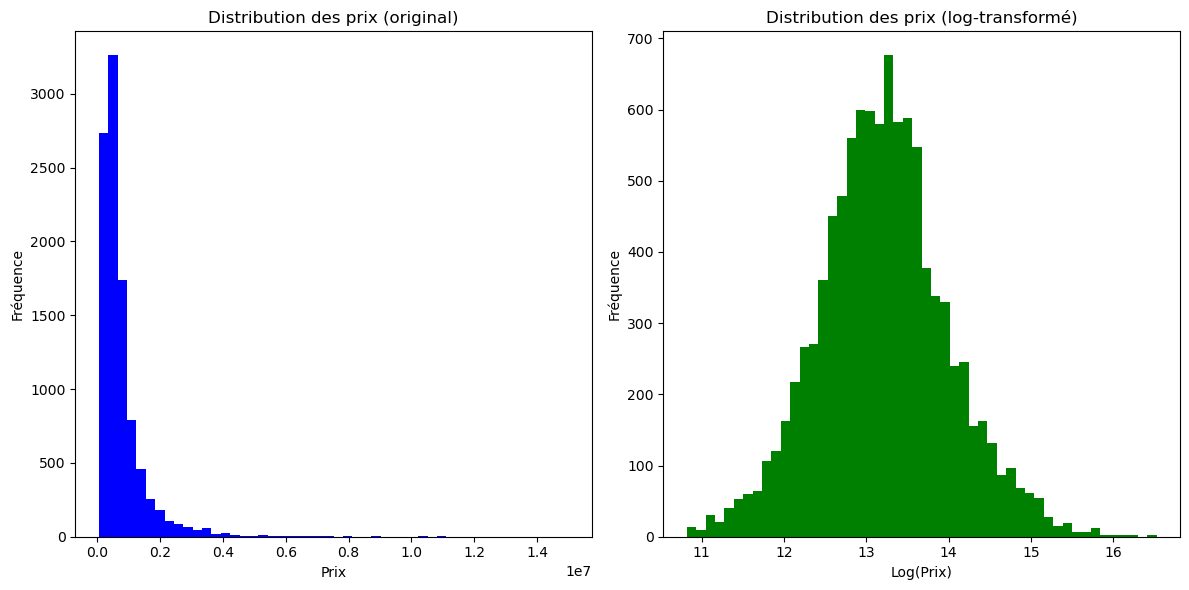

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
df['log(prix)'] = np.log(df['prix']) # transformation logarithmique grâce au np.log de numpy

def graph_distribution_prix(df: pd.DataFrame): # fonction que l'on réutilisera
    plt.figure(figsize=(12, 6)) # taille convenable
    
    # Histogramme avant transformation
    plt.subplot(1, 2, 1) # position à gauche dans le subplot
    plt.hist(df['prix'], bins=50, color='blue') # histogramme avec 50 échantillons 
    plt.title('Distribution des prix (original)')
    plt.xlabel('Prix')
    plt.ylabel('Fréquence')
    
    # Histogramme après transformation
    plt.subplot(1, 2, 2) # position à droite dans le subplot
    plt.hist(df['log(prix)'], bins=50, color='green') # histogramme avec 50 échantillons
    plt.title('Distribution des prix (log-transformé)')
    plt.xlabel('Log(Prix)')
    plt.ylabel('Fréquence')
    
    plt.tight_layout()
    plt.show()



graph_distribution_prix(df)


la log normalisation nous permet de passer d'une distribution fortement asymétrique à une distribution proche d'une gaussienne.

Procédons maintenant à l'analyse descriptive graphique de nos différentes variables.
Pour la variable surface, examinons la distribution du type de bien immobilier.

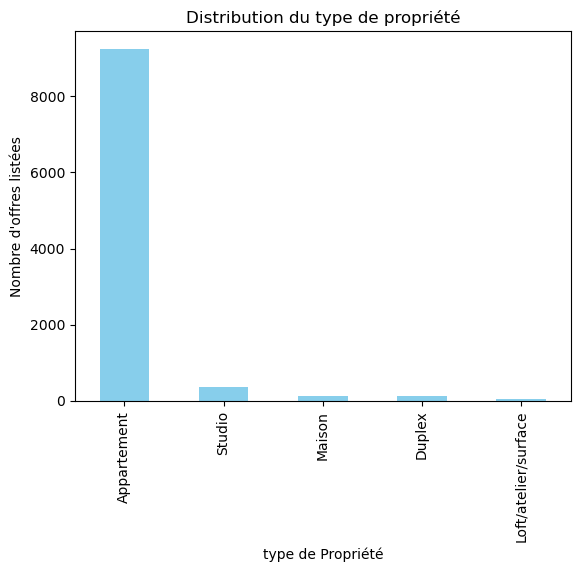

In [440]:
def graph_distribution_type(df: pd.DataFrame): # fonction que l'on réutilisera

    nombre_de_types = df['type'].value_counts() # compte le nombre de biens pour chaque "types" existants
    nombre_de_types.plot(kind='bar', color='skyblue') # crée un diagramme en barres
    plt.title('Distribution du type de propriété')
    plt.xlabel('type de Propriété')
    plt.ylabel("Nombre d'offres listées")
    plt.show()

graph_distribution_type(df)


Sans surprises, la grande majorité des biens offerts sont des appartements, héritages des travaux dirigés par le Baron Haussmann entre 1853 et 1870.  
Cependant les annonces étant remplies par des agences, elles sont sujettes à erreur, surtout pour la catégorisation des biens. Par exemple, pour les petites surfaces, on trouve un certain nombre de studios qui sont catégorisés en tant qu'appartements et inversement. La dénomination choisie de "studio" ne respecte souvent pas la réglementation française (une surface habitable minimale de 9m, une hauteur sous plafond d'au moins 2,20 mètres, un volume habitable d'au moins 20 m3).

Pour les autres types (hors Loft/atelier/surface), intuitivement, ils devraient ajouter de la valeur aux biens. En effet, posséder une maison à Paris raisonne avec exclusivité, de même pour un duplex. Testons cette intuition avec un test t de Student.

In [441]:
from scipy.stats import ttest_ind


prix_maisons = df[df['type'] == 'Maison']['log(prix)'] # log du prix des maisons
prix_duplex = df[df['type'] == 'Duplex']['log(prix)'] # log du prix des duplex
prix_appartements = df[df['type'] == 'Appartement']['log(prix)'] # log du prix des appartements
# on effectue 2 tests t de student en considérant les échantillons comme indépendants et les variance des prix comme étant différentes. 
stat, p_value = ttest_ind(prix_maisons, prix_appartements, equal_var=False) # H0 : la moyenne des prix des appartements et des maisons est égale, H1 : elles sont différentes
stat2, p_value2 = ttest_ind(prix_duplex, prix_appartements, equal_var=False) # H0 : la moyenne des prix des appartements et des duplex est égale, H1 : elles sont différentes

print(f"Pour les Maisons : T-statistic: {stat}, P-value: {p_value}")
print(f"Pour les Duplex : T-statistic: {stat2}, P-value: {p_value2}")



Pour les Maisons : T-statistic: 18.080079794109345, P-value: 1.5278530661557351e-38
Pour les Duplex : T-statistic: 9.290369004963802, P-value: 9.54958434533446e-16


On observe des p.values inférieures à 1%, il y a bien une différence de prix significative entre les appartements d'un côté et les maisons et duplex de l'autre. En prenant en compte la surface des biens on observe que les moyennes sont très proches, et même, que celle des maisons est plus faible. Cela s'explique par le fait qu'un duplex ou une maison nécessite une surface plus grande ce qui, par mètre carré, compense le prix élevé.

In [442]:
prix_par_type = df.groupby('type')['prix/m2'].agg(['mean','median','count']) # on regarde la moyenne, la médiane et le count des prix du m2 des types de biens.
prix_par_type


,mean,median,count
type,,,
Appartement,11093.067505,10401.959566,9252
Duplex,11722.538736,10698.924731,115
Loft/atelier/surface,9896.412507,9749.113868,48
Maison,11688.021663,10454.545455,137
Studio,11010.172108,10645.833333,348


En prenant en compte la surface des biens on observe que les moyennes sont très proches, et même, que celle des maisons est plus faible. Cela s'explique par le fait qu'un duplex ou une maison nécessite une surface plus grande ce qui, par mètre carré, compense le prix élevé.

La question se pose maintenant sur la catégorie Loft/atelier/surface. la moyenne du prix du m2 est de 9438€ soit près de 15% plus faible que la moyenne globale des biens immobiliers. En effet, un loft désigne communément un logement aux espaces ouverts issu d'un ancien atelier/entrepôt. Ces logements sont souvent moins chers au m2 car ils sont souvent destinés à faire office de bureaux de professions libérales ou bien de locaux commerciaux. Bien qu'une partie d'entre eux peuvent être considérés comme appartenant à la catégorie "appartement", nous ne pouvons pas filtrés plus précisément ces biens. Nous décidons ainsi de les supprimer en raison de leur faible nombre.

In [443]:
df = df[df['type'] != "Loft/atelier/surface"]


In [444]:
## # LAS pour loft/atelier/surface
#LAS_listings = df[LAS_condition]
#
#seuil_quantile = LAS_listings['prix/m2'].quantile(0.10)
#
#LAS_filtre = LAS_listings[LAS_listings['prix/m2'] > seuil_quantile]
#
#autres_listings = df[~LAS_condition]

#df = pd.concat([loft_filtre, autres_listings], ignore_index=True)

Intéressons-nous maintenant aux corrélations entre nos différentes variables. On utilise la fonction corr() couplée à la librairie "seaborn" pour les visualiser.

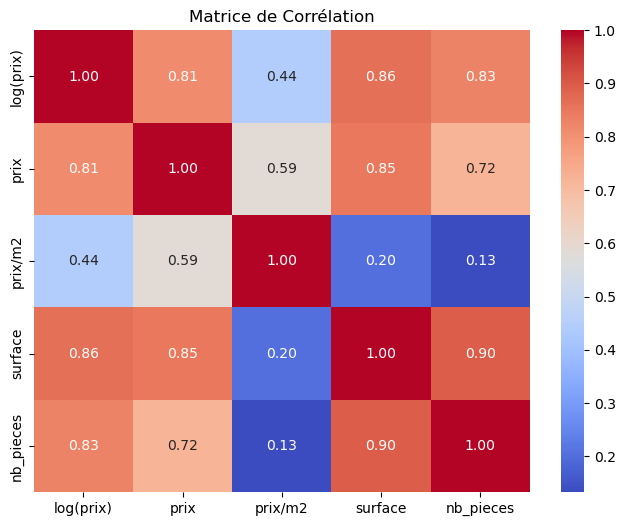

In [445]:
import seaborn as sns


colonnes_numériques = ['log(prix)', 'prix', 'prix/m2', 'surface', 'nb_pieces'] # la corrélation n'a de sens que pour des variables numériques

def graph_correlation_heatmap(df: pd.DataFrame, numerical_cols: list):

    listings_numerique = df[numerical_cols] # dataframe avec nos colonnes numériques
    matrice_corr = listings_numerique.corr() # création de la matrice de corrélation
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrice_corr, annot=True, fmt=".2f", cmap="coolwarm") # heatmap avec les coefficients de corrélation affichés avec deux chiffres après la virgule
    plt.title("Matrice de Corrélation")
    plt.show()

graph_correlation_heatmap(df, colonnes_numériques)


Naturellement, le prix (et le log(prix)) est corrélé positivement avec la surface du bien et son nombre de pièces. En effet, pour le prix on observe une correlation forte, respectivement de 0.85 et 0.72. Intuitivement, si un bien est plus grand ou dispose de plus de pièces, il sera, toute chose égale par ailleurs, plus cher. Cependant, on observe que pour le prix du m2 les corrélations restent positives mais deviennent faibles (0.20 et 0.13 respectivement). Le fait que le prix du m2 soit corrélé positivement avec la surface suggère que l'augmentation du prix du bien surpasse l'augmentation de la surface. Ce phénomène peut paraître contre-intuitif pour certaines surfaces. Pour clarifier, nous analysons le coefficient de Pearson entre le prix du m2 et la surface selon les quantiles de la surface.

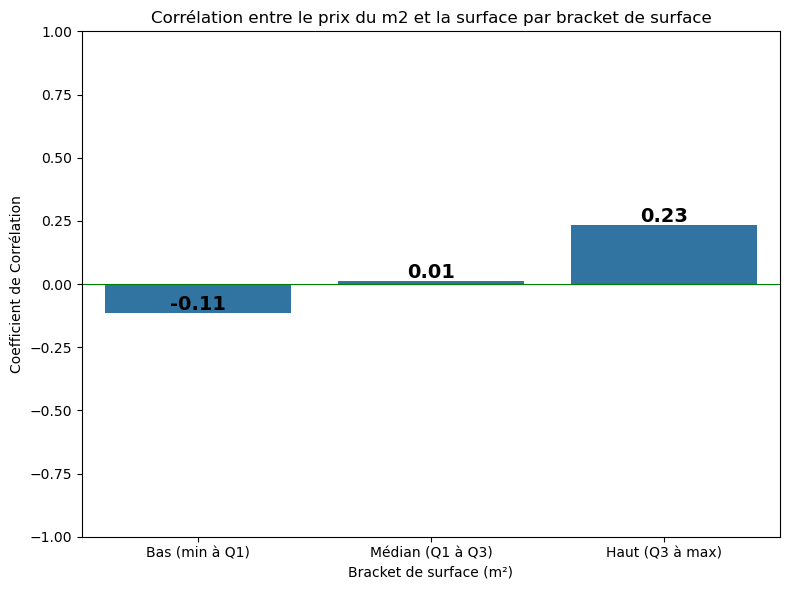

In [446]:

def graph_bar_correlation_bracket(df: pd.DataFrame):

    Q1 = df['surface'].quantile(0.25)
    Q2 = df['surface'].quantile(0.50)
    Q3 = df['surface'].quantile(0.75)
    
    # Définition des brackets

    # on définit des échantillons (des "brackets"), ici on catégorise les biens de façon arbitraire selon les quantiles de surface
    bins = [df['surface'].min(), Q1, Q3, df['surface'].max()] 
    labels = ['Bas (min à Q1)', 'Médian (Q1 à Q3)', 'Haut (Q3 à max)'] 

    # Crée une nouvelle colonne 'surface_bracket' en classant les valeurs de la surface selon les intervalles prédéfinis
    df['surface_bracket'] = pd.cut(df['surface'], bins=bins, labels=labels, include_lowest=True) 



    # Calcul des corrélations par bracket
    correlation_dict = {}
    for bracket in labels: # loop sur chaque intervalle prédéfini
        subset = df[df['surface_bracket'] == bracket] # dataframe contenant que les logements appartenant à l'intervalle de l'itération
        corr = subset['prix/m2'].corr(subset['surface'], method='pearson') # coefficient de corrélation de Pearson entre le prix du m2 et la surface
        correlation_dict[bracket] = corr
    
  
    # crée un dataframe à partir du dictionnaire de corrélation
    corr_listings = pd.DataFrame.from_dict(correlation_dict, orient='index', columns=['Corrélation']).reset_index().rename(columns={'index': 'Bracket de surface'}) 
    corr_listings = corr_listings.sort_values('Bracket de surface') # tri croissant pour le graphique
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Bracket de surface', y='Corrélation', data=corr_listings, order=labels) # graphique de barres dans l'ordre prédéfini
    
    for index, row in corr_listings.iterrows():
        # affichage des coefficients sur chaque barre
        plt.text(index, row.Corrélation+0.01, f"{row.Corrélation:.2f}", ha='center', fontsize = 14, fontweight ='bold')
    
    plt.title('Corrélation entre le prix du m2 et la surface par bracket de surface')
    plt.ylim(-1, 1) # la corrélation est à valeurs dans [-1,1]
    plt.ylabel('Coefficient de Corrélation')
    plt.xlabel('Bracket de surface (m²)')
    plt.axhline(0, color='green', linewidth=0.8) # ligne : coefficient de corrélation = 0 
    plt.tight_layout()
    plt.show()

graph_bar_correlation_bracket(df)

Ce résultat souligne la diversité des segments du marché parisien. Une interprétation possible est que les grandes surfaces étant souvent destinés à des familles dont le budget est plus élevé (ou des investisseurs), ceux-ci valorisent d'avantage la qualité du bien que son prix du m2, ainsi, une augmentation de la surface peut justifier un prix plus élevé du m2. La demande est moins élastique et la rareté accentue le prix/m² à mesure que la surface augmente.\
Pour les plus petits logements, le prix du m2 est initialement élevé car ils sont souvent des biens d'investissements (studio/appartement étudiant/Airbnb). De ce fait, ajouter quelques mètres carrés dans cette gamme ne rehausse pas forcément la valeur au m² si l’appartement reste, par exemple, un T1 plutôt qu’un T2. En d’autres termes, une studette de 15 m² à 18 m² ne modifie pas drastiquement l’attrait du bien pour les investisseurs. Le loyer potentiel n’augmentant pas proportionnellement.\
Pour les biens "médians", souvent recherchés par la "classe moyenne", la surface reste importante mais d'autres facteurs pèsent autant que le prix au m2. On peut citer l'étage, la localisation ou la luminosité.

Afin de préparer la modélisation du prix du m2 d'un logement parisien, il nous est nécessaire d'identifier les "outliers" qui pourrait nous poser des problèmes. On utilise une approche graphique.

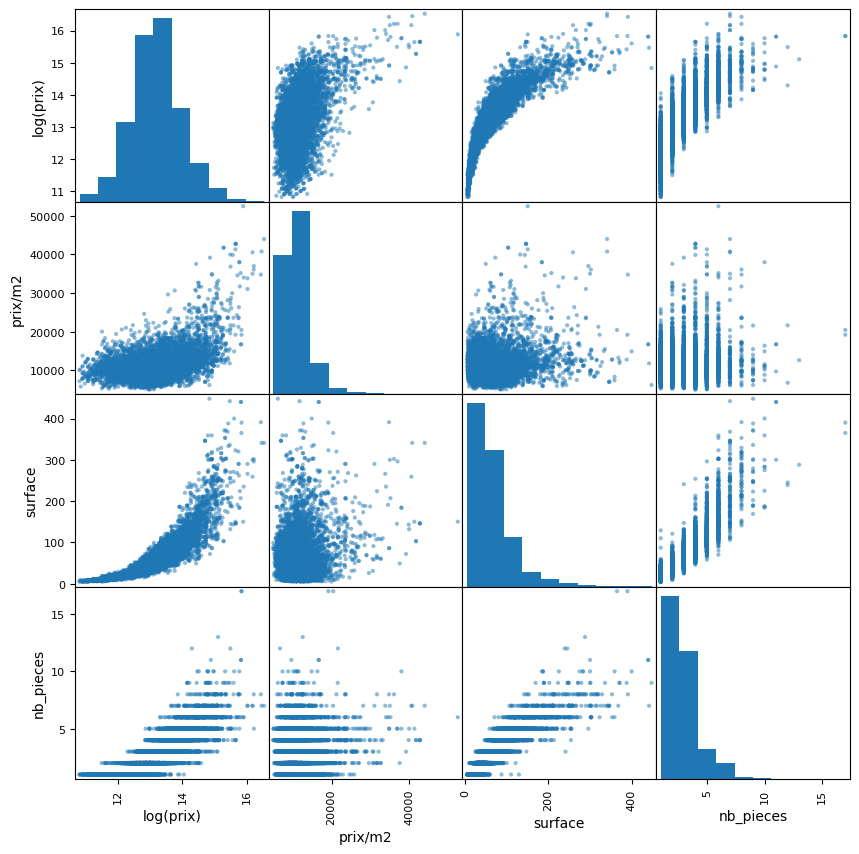

In [447]:
colonnes_graphiques = ["log(prix)", "prix/m2", "surface", "nb_pieces"]
def graph_matrice_scatter(df: pd.DataFrame, numerical_cols: list):
    # Génère une matrice de graphiques de dispersion (scatter plots) pour toutes nos variables numériques
    pd.plotting.scatter_matrix(df[colonnes_graphiques], figsize=(10, 10))  
    plt.show()

graph_matrice_scatter(df,colonnes_numériques)

Sur ce graphique on retrouve les différentes conclusions précédemment présentées. Nous voyons en diagonale les distributions plus ou moins asymétriques. De plus on retrouve à la première et deuxième lignes les corrélations positives du prix ou log(prix) aux pièces et surface et les corrélations plus flous du prix du m2 à la troisème ligne.
Ce graphique nous permet d'identifier les points extrêmes ("outliers") et de juger de la pertinence de les conserver dans le cadre de notre modélisation.

Premier outlier : un logement avec un prix du m2 très élevé pour son nombre de pièces et sa surface.

In [448]:
df[colonnes_analyses].loc[df["prix/m2"] > 50000] # garde le(s) propriété(s) avec un prix du m2 supérieur à 50 000€

,id,type,nb_pieces,prix,prix/m2,surface,loc1
1139,apimo-7012481,Appartement,6,7875000,52500.0,150,Triangle d'Or


Il s'agit donc d'un appartement à 52500€ le m2 ce qui est près de 5 fois plus que la moyenne. Cependant, cela pourrait en partie s'expliquer par le sous-quartier exclusif du "Triangle d'Or", terme caractérisant une zone géographique prestigieuse et haut de gamme dans plusieurs villes françaises. Entres autres, à Paris, le Triangle d'Or est délimité par les avenues Montaigne, des Champs-Élysées et George-V. Comparons alors ce prix pharamineux aux autres logements offerts dans le Triangle d'Or.

In [449]:
df.groupby('loc1')['prix/m2'].mean()["Triangle d'Or"]

np.float64(22422.484155707294)

La propriété a un prix par m2 deux fois plus élevé que la moyenne du quartier qui est elle même déjà exceptionnellement haute. afin de négliger l'effet inflationniste et non représentatif de ce bien sur notre modèle, nous décidons de supprimer cette offre.   

In [450]:
df = df.drop(index = df['prix/m2'].idxmax())

Nous avons très peu de données pour les logements d'ultra luxe comportant au moins 13 pièces. De plus sur ce segment, les prix varient substantiellement car les appartements comportent des caractéristiques très exclusives qui justifient (pour certains) leur prix. Notre scraping ne nous permet cependant pas de quantifier ces caractéristiques spécifiques. Ainsi nous décidons d'enlever ces données non représentatives.

In [451]:
print(f"on supprime {df[df['nb_pieces'] >= 9].shape[0]} annonces")
df = df[df['nb_pieces'] < 9]

on supprime 38 annonces


In [452]:
description_listings(df)

Le logement médian à Paris fait 52 m2, comporte 2 pièces et coûte 530000€ soit 10419€ du m2 (avec frais d'agence et notarial)


,nb_pieces,prix,prix/m2,surface
count,9813.00,9813.00,9813.00,9813.00
mean,2.75,737479.59,11095.28,63.51
std,1.47,770797.81,3475.54,46.15
min,1.00,50000.00,5000.00,4.00
25%,2.00,325000.00,9021.74,32.00
50%,2.00,530000.00,10418.60,52.00
75%,4.00,850000.00,12291.67,82.00
max,8.00,15000000.00,43988.27,442.00


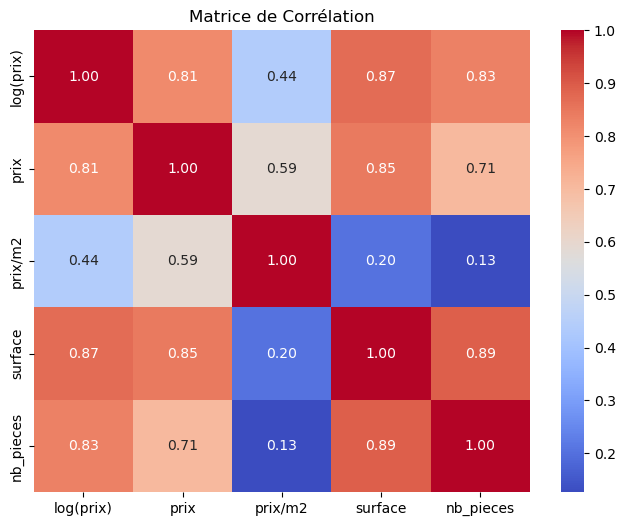

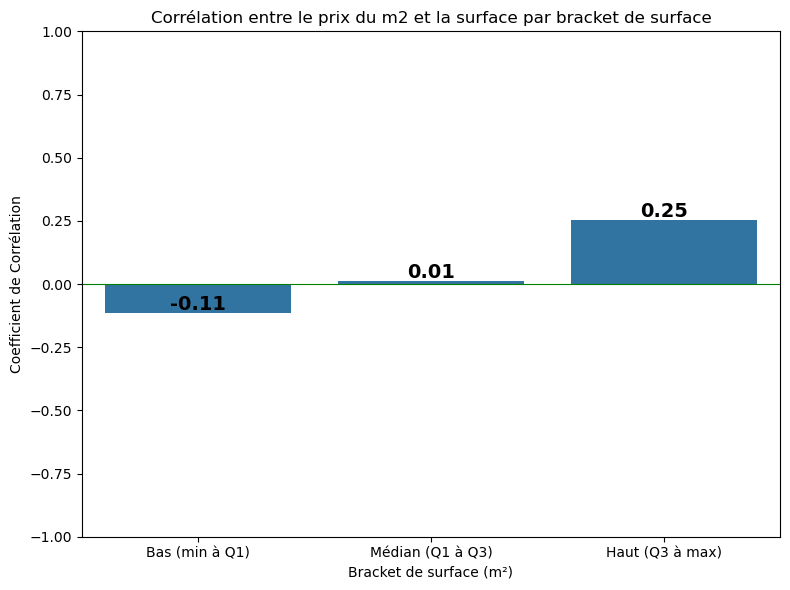

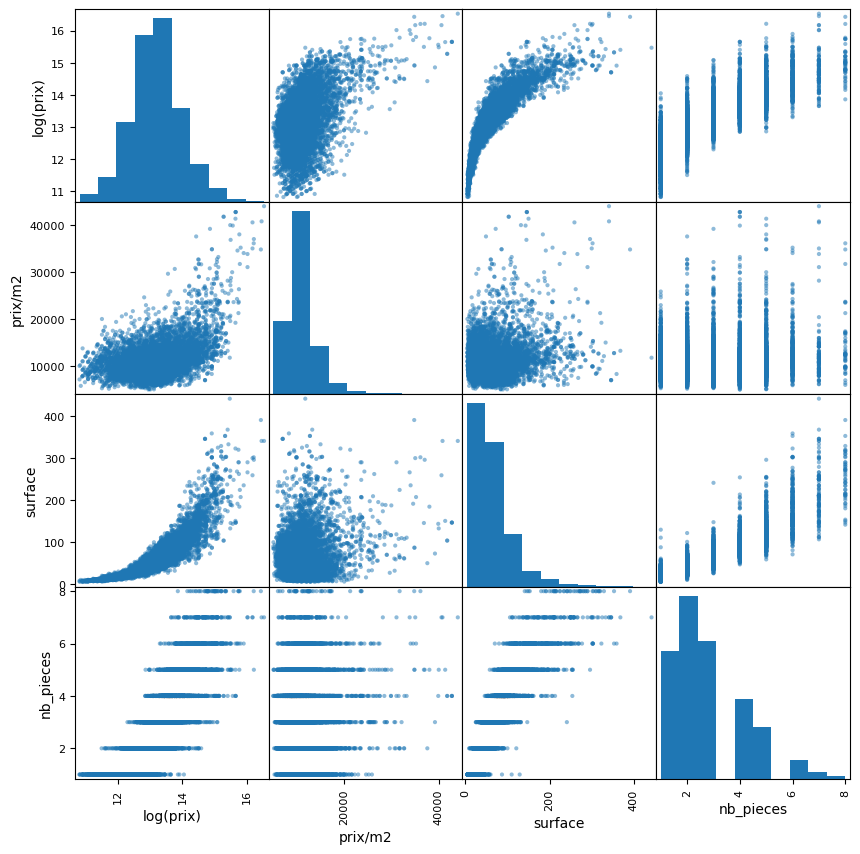

In [453]:
graph_correlation_heatmap(df,colonnes_numériques)
graph_bar_correlation_bracket(df)
graph_matrice_scatter(df, colonnes_numériques)

On observe que nos retraitements n'impactent pas les conclusions précédemment mentionnées. Les distributions restent similaires tout comme les corrélations.

Avant de passer à la modélisation, nous souhaitons utiliser les données de localisation que nous avons scrappées afin de réaliser une carte des niveaux de prix du m2 des différentes zones. on utilise la librairie "folium" pour faire des cartes.

In [454]:
import folium

In [455]:
### CREATION DE LA CARTE ###

# Initialiser la carte centrée sur Paris
carte = folium.Map(location=[48.8566, 2.3522], zoom_start=12)
df_unique = df.drop_duplicates(subset=['loc1_x', 'loc1_y'])
# Ajouter des points sur la carte pour les adresses avec coordonnées
for idx, row in df_unique.iterrows():
    lat = row['loc1_x']
    lon = row['loc1_y']
    if pd.notna(lat) and pd.notna(lon):
        folium.Marker(
            location=[lat, lon],
            popup=f"{row['loc1']}",  # Texte affiché lorsqu'on clique sur le point
            icon=folium.Icon(color="blue", icon="info-sign")
        ).add_to(carte)

# Sauvegarder la carte dans un fichier HTML
carte.save("carte_paris_points.html")
print("Carte créée : carte_paris_points.html")

Carte créée : carte_paris_points.html


In [456]:
## Affichage de la carte
carte

In [457]:
## Regrouper par 'loc1' et calculer la moyenne des prix, des surfaces et le nombre d'annonces
#resultat = df.groupby('loc1', as_index=False).agg(
#    moyenne_prix=('prix', 'mean'),      # Moyenne des prix
#    moyenne_surface=('surface', 'mean'),  # Moyenne des surfaces
#    nombre_annonces=('prix', 'size'),   # Nombre d'annonces (compte les lignes)
#    latitude=('loc1_x', 'first'),         # Latitude (première valeur)
#    longitude=('loc1_y', 'first')        # Longitude (première valeur))
#)
## Calculer la moyenne des prix au m²
#resultat['prix_m2'] = resultat['moyenne_prix'] / resultat['moyenne_surface']
#resultat.dropna(inplace=True)
#
#
#resultat2 = df.groupby('loc2', as_index=False).agg(
#    moyenne_prix=('prix', 'mean'),      # Moyenne des prix
#    moyenne_surface=('surface', 'mean'),  # Moyenne des surfaces
#    nombre_annonces=('prix', 'size'),   # Nombre d'annonces (compte les lignes)
#    latitude2=('loc2_x', 'first'),         # Latitude (première valeur)
#    longitude2=('loc2_y', 'first')        # Longitude (première valeur))
#)
## Calculer la moyenne des prix au m²
#resultat2['prix_m2'] = resultat2['moyenne_prix'] / resultat2['moyenne_surface']
#resultat2.dropna(inplace=True)
#
#resultat3 = df.groupby('loc3', as_index=False).agg(
#    moyenne_prix=('prix', 'mean'),      # Moyenne des prix
#    moyenne_surface=('surface', 'mean'),  # Moyenne des surfaces
#    nombre_annonces=('prix', 'size'),   # Nombre d'annonces (compte les lignes)
#    latitude3=('loc3_x', 'first'),         # Latitude (première valeur)
#    longitude3=('loc3_y', 'first')        # Longitude (première valeur))
#)
## Calculer la moyenne des prix au m²
#resultat3['prix_m2'] = resultat3['moyenne_prix'] / resultat3['moyenne_surface']
#resultat3.dropna(inplace=True)
## Supprimer les colonnes intermédiaires si elles ne sont pas nécessaires
##resultat = resultat[['loc1', 'prix_m2', 'nombre_annonces','loc1_x','loc1_y']]  # Garder uniquement loc1, prix_m2 et nombre d'annonces
#

In [458]:
#import matplotlib.colors as mcolors
#def prix_m2_to_color(prix_m2, min_price, max_price):
#    """
#    Map the prix_m2 to a color.
#    Green for lowest prix_m2, red for highest, with gradient in between.
#    """
#    # Normalize the prix_m2 between 0 and 1
#    norm = (prix_m2 - min_price) / (max_price - min_price)
#    # Use a colormap (e.g., 'RdYlGn') and invert it so that higher prices are red
#    cmap = plt.cm.get_cmap('RdYlGn_r')
#    # Get the RGBA color and convert it to HEX
#    color = mcolors.to_hex(cmap(norm))
#    return color
#
#min_price_m2 = resultat['prix_m2'].min()
#max_price_m2 = resultat['prix_m2'].max()
#min_annonces = resultat['nombre_annonces'].min()
#max_annonces = resultat['nombre_annonces'].max()
#
#
## Normaliser les tailles des points en fonction du nombre d'annonces
#min_radius = 5
#max_radius = 20
#
#def scale_radius(nombre_annonces):
#    return min_radius + (max_radius - min_radius) * (nombre_annonces - resultat['nombre_annonces'].min()) / (resultat['nombre_annonces'].max() - resultat['nombre_annonces'].min())
#
## Création de la carte
#carte = folium.Map(location=[48.8566, 2.3522], zoom_start=12)
#
## Ajout des points
#for _, row in resultat.iterrows():
#    couleur = prix_m2_to_color(row['prix_m2'], min_price_m2, max_price_m2)  # Couleur basée sur le prix/m²
#    radius = scale_radius(row['nombre_annonces'])  # Taille basée sur le nombre d'annonces
#    folium.CircleMarker(
#        location=[row['latitude'], row['longitude']],
#        radius=radius,  # Taille des points
#        color='black',  # Contour noir
#        fill=True,
#        fill_color=couleur,  # Remplissage rouge
#        fill_opacity=0.9,
#        popup=f"{row['loc1']}<br>Prix/m² : {row['prix_m2']:.2f} €<br>Nombre d'annonces : {row['nombre_annonces']}"
#    ).add_to(carte)
#
## Sauvegarder la carte
#carte.save("carte_prix_m2_taille.html")
#print("Carte créée : carte_prix_m2_taille.html")

In [459]:
#carte2 = folium.Map(location=[48.8566, 2.3522], zoom_start=12)
#for _, row in resultat2.iterrows():
#    couleur = prix_m2_to_color(row['prix_m2'], min_price_m2, max_price_m2)  # Couleur basée sur le prix/m²
#    radius = scale_radius(row['nombre_annonces'])  # Taille basée sur le nombre d'annonces
#    folium.CircleMarker(
#        location=[row['latitude2'], row['longitude2']],
#        radius=radius,  # Taille des points
#        color='black',  # Contour noir
#        fill=True,
#        fill_color=couleur,  # Remplissage rouge
#        fill_opacity=0.9,
#        popup=f"{row['loc2']}<br>Prix/m² : {row['prix_m2']:.2f} €<br>Nombre d'annonces : {row['nombre_annonces']}"
#    ).add_to(carte2)
#
## Sauvegarder la carte
#carte2.save("carte_prix_m2_taille_2.html")
#print("Carte créée : carte_prix_m2_taille_2.html")
#

In [460]:
#carte3 = folium.Map(location=[48.8566, 2.3522], zoom_start=12)
#for _, row in resultat3.iterrows():
#    couleur = prix_m2_to_color(row['prix_m2'], min_price_m2, max_price_m2)  # Couleur basée sur le prix/m²
#    radius = scale_radius(row['nombre_annonces'])  # Taille basée sur le nombre d'annonces
#    folium.CircleMarker(
#        location=[row['latitude3'], row['longitude3']],
#        radius=radius,  # Taille des points
#        color='black',  # Contour noir
#        fill=True,
#        fill_color=couleur,  # Remplissage rouge
#        fill_opacity=0.9,
#        popup=f"{row['loc3']}<br>Prix/m² : {row['prix_m2']:.2f} €<br>Nombre d'annonces : {row['nombre_annonces']}"
#    ).add_to(carte3)
#
## Sauvegarder la carte
#carte3.save("carte_prix_m2_taille_3.html")
#print("Carte créée : carte_prix_m2_taille_3.html")
#

In [461]:
# Plus la couleur est clair plus le prix/m² est faible. 
# Inversement, plus la couleur est élevée plus le prix/m² est élevée. 
# Afficher la carte : 
carte


In [462]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming 'df' is your DataFrame and it's already loaded

# Définir les niveaux de localisation et leurs colonnes de latitude et longitude correspondantes
location_levels = {
    'loc1': {'lat_col': 'loc1_x', 'lon_col': 'loc1_y'},
    'loc2': {'lat_col': 'loc2_x', 'lon_col': 'loc2_y'},
    'loc3': {'lat_col': 'loc3_x', 'lon_col': 'loc3_y'}
}

# Fonction pour mapper le prix/m² à une couleur
def prix_m2_to_color(prix_m2, min_price, max_price):
    # Normaliser le prix/m² entre 0 et 1
    norm = (prix_m2 - min_price) / (max_price - min_price) if max_price != min_price else 0.5
    # Utiliser une palette de couleurs (par exemple, 'RdYlGn') et l'inverser pour que les prix élevés soient en rouge
    cmap = plt.cm.get_cmap('RdYlGn_r')
    # Obtenir la couleur RGBA et la convertir en HEX
    color = mcolors.to_hex(cmap(norm))
    return color

# Fonction pour normaliser la taille des points en fonction du nombre d'annonces
def scale_radius(nombre_annonces, min_annonces, max_annonces, min_radius=5, max_radius=20):
    return min_radius + (max_radius - min_radius) * (nombre_annonces - min_annonces) / (max_annonces - min_annonces)

cartes = []

# Itérer sur chaque niveau de localisation
for loc, cols in location_levels.items():
    print(f"Traitement de {loc}...")

    # Regrouper par le niveau de localisation actuel
    résultat = df.groupby(loc, as_index=False).agg(
        moyenne_prix=('prix', 'mean'),      # Moyenne des prix
        moyenne_surface=('surface', 'mean'),  # Moyenne des surfaces
        nombre_annonces=('prix', 'size'),   # Nombre d'annonces (compte les lignes)
        latitude=(cols['lat_col'], 'first'),  # Latitude (première valeur)
        longitude=(cols['lon_col'], 'first')  # Longitude (première valeur)
    )

    # Calculer la moyenne des prix au m²
    résultat['prix_m2'] = résultat['moyenne_prix'] / résultat['moyenne_surface']
    résultat.dropna(inplace=True)

    # Déterminer les valeurs min et max pour la normalisation
    min_price_m2 = résultat['prix_m2'].min()
    max_price_m2 = résultat['prix_m2'].max()
    min_annonces = résultat['nombre_annonces'].min()
    max_annonces = résultat['nombre_annonces'].max()

    # Création de la carte
    carte = folium.Map(location=[48.8566, 2.3522], zoom_start=12)  # Centrée sur Paris ; ajuster si nécessaire

    # Ajouter les points sur la carte
    for _, row in résultat.iterrows():
        couleur = prix_m2_to_color(row['prix_m2'], min_price_m2, max_price_m2)  # Couleur basée sur le prix/m²
        radius = scale_radius(row['nombre_annonces'], min_annonces, max_annonces)  # Taille basée sur le nombre d'annonces
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=radius,  # Taille des points
            color='black',  # Contour noir
            fill=True,
            fill_color=couleur,  # Remplissage coloré
            fill_opacity=0.9,
            popup=(
                f"{row[loc]}<br>"
                f"Prix/m² : {row['prix_m2']:.2f} €<br>"
                f"Nombre d'annonces : {row['nombre_annonces']}"
            )
        ).add_to(carte)
    cartes.append(carte)
    # Sauvegarder la carte
    map_filename = f"carte_prix_m2_taille_{loc[-1]}.html"  # ex. carte_prix_m2_taille_1.html
    carte.save(map_filename)
    print(f"Carte créée : {map_filename}\n")

for i, carte in enumerate(cartes):
    print(f"Affichage de la carte {i+1} :")
    display(carte)

Traitement de loc1...


/tmp/ipykernel_495157/1612466280.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlGn_r')


Carte créée : carte_prix_m2_taille_1.html

Traitement de loc2...
Carte créée : carte_prix_m2_taille_2.html

Traitement de loc3...


/tmp/ipykernel_495157/1612466280.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlGn_r')
/tmp/ipykernel_495157/1612466280.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlGn_r')


Carte créée : carte_prix_m2_taille_3.html

Affichage de la carte 1 :


Affichage de la carte 2 :


Affichage de la carte 3 :
